In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from efficientkan import KAN

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors and scale to [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [3]:
class MyMLP(nn.Module):

    def __init__(self, layers: list):
        super(MyMLP, self).__init__()

        to_sequential, self.num_parameters = self.build_layers_and_count_params(layers)
        self.layers = nn.Sequential(*to_sequential)

    def forward(self, x):
        return self.layers(x)


    # given a list of layer sizes, builds the respective linear layers with ReLU activation functions.
    # Also returns the total number of parameters of the model.
    def build_layers_and_count_params(self, layers):

        to_sequential = []
        num_parameters = 0

        for i in range(len(layers) - 1):

            to_sequential.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                to_sequential.append(nn.ReLU())

            num_parameters += layers[i]*layers[i+1] + layers[i+1]

        return to_sequential, num_parameters




class MyKAN(nn.Module):

    def __init__(self, layers: list, grid_size):
        super(MyKAN, self).__init__()

        self.num_parameters = self.count_params(layers, grid_size)
        self.layers = KAN(layers, grid_size=grid_size)


    def forward(self, x):
        return self.layers(x)


    def count_params(self, layers, grid_size):

        num_parameters = 0

        for i in range(len(layers) - 1):
            num_parameters += layers[i]*layers[i+1]

        return num_parameters * grid_size

In [4]:
def train_and_evaluate(model, trainloader, valloader, device, num_epochs, optimizer, criterion):

    lr = optimizer.param_groups[0]['lr']
    print(f'Training model "{model.__class__.__name__}" with device: {device} and parameters:' if device=='cpu' else f'Training model "{model.__class__.__name__}" with device: {device} ({torch.cuda.get_device_name()}) and parameters:')
    print(f'\tLearning rate: {lr}\n\tLoss function: {criterion}\n\tOptimizer: {optimizer.__class__.__name__}\n')
    print(f'Number of parameters: {model.num_parameters}\n')

    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []

    for epoch in range(num_epochs):

# Train
        model.train()
        train_loss = 0
        train_acc = 0

        start = time()

        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)

                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                train_acc += accuracy.item()

        train_losses.append(train_loss / i)
        train_accs.append(train_acc / i)

        t = time()-start
        times.append(t)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / i:.4f}, Train Accuracy: {train_acc / i:.4f}, Time: {t:.2f}s")


# Validation
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(valloader):
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)

                val_loss += criterion(output, labels.to(device)).item()
                val_acc += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())

        val_losses.append(val_loss / i)
        val_accs.append(val_acc / i)

        print(f"\t      Valid Loss: {val_loss / i:.4f}, Valid Accuracy: {val_acc / i:.4f}\n")


    return train_losses, train_accs, val_losses, val_accs, times

In [5]:
def build_data_frame(model, num_epochs, train_losses, val_losses, train_accs, val_accs, time, separator):

    df = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses],
        'Loss (v)': [i for i in val_losses],
        'Accuracy (t)': [i for i in train_accs],
        'Accuracy (v)': [i for i in val_accs],
        'Time': [i for i in time]
        })
    
    df = pd.concat([df, pd.DataFrame([{'Epoch': 'Mean', 'Time': df['Time'].mean()}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{'Epoch': f'Params: {model.num_parameters}'}])], ignore_index=True)
    df = pd.concat([df, separator], ignore_index=True)

    return df

In [6]:
# Define models and parameters

model_list_mlp = [
  #  MyMLP([28*28, 128, 10]),
  #  MyMLP([28*28, 64, 10]),
  #  MyMLP([28*28, 10, 10]),
     MyMLP([28*28, 5, 10]),
  #  MyMLP([28*28, 10, 10, 10]),
  #  MyMLP([28*28, 5, 5, 10]),
    ]
model_list_kan = [
     MyKAN([28*28, 128, 10], grid_size=3),
  #  MyKAN([28*28, 64, 10], grid_size=3),
  #  MyKAN([28*28, 10, 10], grid_size=3),
  #  MyKAN([28*28, 5, 10], grid_size=3),
  #  MyKAN([28*28, 10, 10, 10], grid_size=3),
  #  MyKAN([28*28, 5, 5, 10], grid_size=3)
    ]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

df_mlp = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
df_kan = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
separator = pd.DataFrame({'Epoch' : ['---'], 'Loss (t)' : ['---'], 'Loss (v)': ['---'], 'Accuracy (t)': ['---'], 'Accuracy (v)': ['---'], 'Time': ['---']})

for model_mlp, model_kan in zip(model_list_mlp, model_list_kan):

    optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
    train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp = train_and_evaluate(model_mlp, trainloader, valloader, device, num_epochs, optimizer_mlp, criterion)

    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan = train_and_evaluate(model_kan, trainloader, valloader, device, num_epochs, optimizer_kan, criterion)

    single_df_mlp = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses_mlp],
        'Loss (v)': [i for i in val_losses_mlp],
        'Accuracy (t)': [i for i in train_accs_mlp],
        'Accuracy (v)': [i for i in val_accs_mlp],
        'Time': [i for i in time_mlp]
        })

    single_df_kan = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses_kan],
        'Loss (v)': [i for i in val_losses_kan],
        'Accuracy (t)': [i for i in train_accs_kan],
        'Accuracy (v)': [i for i in val_accs_kan],
        'Time': [i for i in time_kan]
        })

    means_mlp = {'Epoch': 'Mean', 'Time': single_df_mlp['Time'].mean()}
    means_kan = {'Epoch': 'Mean', 'Time': single_df_kan['Time'].mean()}

    num_params_mlp = {'Epoch': f'Params: {model_mlp.num_parameters}'}
    num_params_kan = {'Epoch': f'Params: {model_kan.num_parameters}'}

    single_df_mlp = pd.concat([single_df_mlp, pd.DataFrame([means_mlp])], ignore_index=True)
    single_df_mlp = pd.concat([single_df_mlp, pd.DataFrame([num_params_mlp])], ignore_index=True)
    single_df_mlp = pd.concat([single_df_mlp, separator], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, pd.DataFrame([means_kan])], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, pd.DataFrame([num_params_kan])], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, separator], ignore_index=True)

    df_mlp = pd.concat([df_mlp, single_df_mlp], ignore_index=True)
    df_kan = pd.concat([df_kan, single_df_kan], ignore_index=True)

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 3985



100%|██████████| 938/938 [00:07<00:00, 128.93it/s]


Epoch [1/10], Train Loss: 1.3025, Train Accuracy: 0.5477, Time: 7.28s
	      Valid Loss: 0.9646, Valid Accuracy: 0.6983



100%|██████████| 938/938 [00:06<00:00, 140.49it/s]


Epoch [2/10], Train Loss: 0.9265, Train Accuracy: 0.7016, Time: 6.68s
	      Valid Loss: 0.8755, Valid Accuracy: 0.7314



100%|██████████| 938/938 [00:06<00:00, 141.04it/s]


Epoch [3/10], Train Loss: 0.8577, Train Accuracy: 0.7300, Time: 6.65s
	      Valid Loss: 0.8261, Valid Accuracy: 0.7511



100%|██████████| 938/938 [00:06<00:00, 141.96it/s]


Epoch [4/10], Train Loss: 0.8122, Train Accuracy: 0.7461, Time: 6.61s
	      Valid Loss: 0.7769, Valid Accuracy: 0.7662



100%|██████████| 938/938 [00:06<00:00, 147.87it/s]


Epoch [5/10], Train Loss: 0.7830, Train Accuracy: 0.7535, Time: 6.34s
	      Valid Loss: 0.7909, Valid Accuracy: 0.7562



100%|██████████| 938/938 [00:06<00:00, 145.82it/s]


Epoch [6/10], Train Loss: 0.7654, Train Accuracy: 0.7584, Time: 6.43s
	      Valid Loss: 0.7667, Valid Accuracy: 0.7644



100%|██████████| 938/938 [00:06<00:00, 145.14it/s]


Epoch [7/10], Train Loss: 0.7528, Train Accuracy: 0.7637, Time: 6.46s
	      Valid Loss: 0.7448, Valid Accuracy: 0.7720



100%|██████████| 938/938 [00:06<00:00, 145.35it/s]


Epoch [8/10], Train Loss: 0.7428, Train Accuracy: 0.7654, Time: 6.45s
	      Valid Loss: 0.7371, Valid Accuracy: 0.7768



100%|██████████| 938/938 [00:06<00:00, 147.19it/s]


Epoch [9/10], Train Loss: 0.7359, Train Accuracy: 0.7678, Time: 6.37s
	      Valid Loss: 0.7284, Valid Accuracy: 0.7788



100%|██████████| 938/938 [00:06<00:00, 146.32it/s]


Epoch [10/10], Train Loss: 0.7289, Train Accuracy: 0.7701, Time: 6.41s
	      Valid Loss: 0.7279, Valid Accuracy: 0.7736

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 304896



100%|██████████| 938/938 [00:07<00:00, 120.48it/s]


Epoch [1/10], Train Loss: 0.3615, Train Accuracy: 0.8978, Time: 7.79s
	      Valid Loss: 0.1935, Valid Accuracy: 0.9484



100%|██████████| 938/938 [00:07<00:00, 122.92it/s]


Epoch [2/10], Train Loss: 0.1520, Train Accuracy: 0.9566, Time: 7.63s
	      Valid Loss: 0.1193, Valid Accuracy: 0.9705



100%|██████████| 938/938 [00:07<00:00, 125.92it/s]


Epoch [3/10], Train Loss: 0.0940, Train Accuracy: 0.9731, Time: 7.45s
	      Valid Loss: 0.0921, Valid Accuracy: 0.9787



100%|██████████| 938/938 [00:07<00:00, 125.96it/s]


Epoch [4/10], Train Loss: 0.0663, Train Accuracy: 0.9812, Time: 7.45s
	      Valid Loss: 0.0778, Valid Accuracy: 0.9819



100%|██████████| 938/938 [00:07<00:00, 125.35it/s]


Epoch [5/10], Train Loss: 0.0493, Train Accuracy: 0.9866, Time: 7.48s
	      Valid Loss: 0.0870, Valid Accuracy: 0.9779



100%|██████████| 938/938 [00:07<00:00, 124.86it/s]


Epoch [6/10], Train Loss: 0.0389, Train Accuracy: 0.9896, Time: 7.51s
	      Valid Loss: 0.0877, Valid Accuracy: 0.9797



100%|██████████| 938/938 [00:07<00:00, 125.43it/s]


Epoch [7/10], Train Loss: 0.0295, Train Accuracy: 0.9924, Time: 7.48s
	      Valid Loss: 0.0744, Valid Accuracy: 0.9829



100%|██████████| 938/938 [00:07<00:00, 126.13it/s]


Epoch [8/10], Train Loss: 0.0251, Train Accuracy: 0.9936, Time: 7.44s
	      Valid Loss: 0.0734, Valid Accuracy: 0.9832



100%|██████████| 938/938 [00:07<00:00, 121.51it/s]


Epoch [9/10], Train Loss: 0.0197, Train Accuracy: 0.9950, Time: 7.72s
	      Valid Loss: 0.0779, Valid Accuracy: 0.9830



100%|██████████| 938/938 [00:07<00:00, 125.03it/s]


Epoch [10/10], Train Loss: 0.0197, Train Accuracy: 0.9946, Time: 7.50s
	      Valid Loss: 0.0901, Valid Accuracy: 0.9813



In [7]:
#print(df_mlp)
df_mlp.to_csv('results_mlp.csv', index = False)
df_kan.to_csv('results_kan.csv', index = False)

Plotting MLP

/tmp/ipykernel_16179/373705896.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


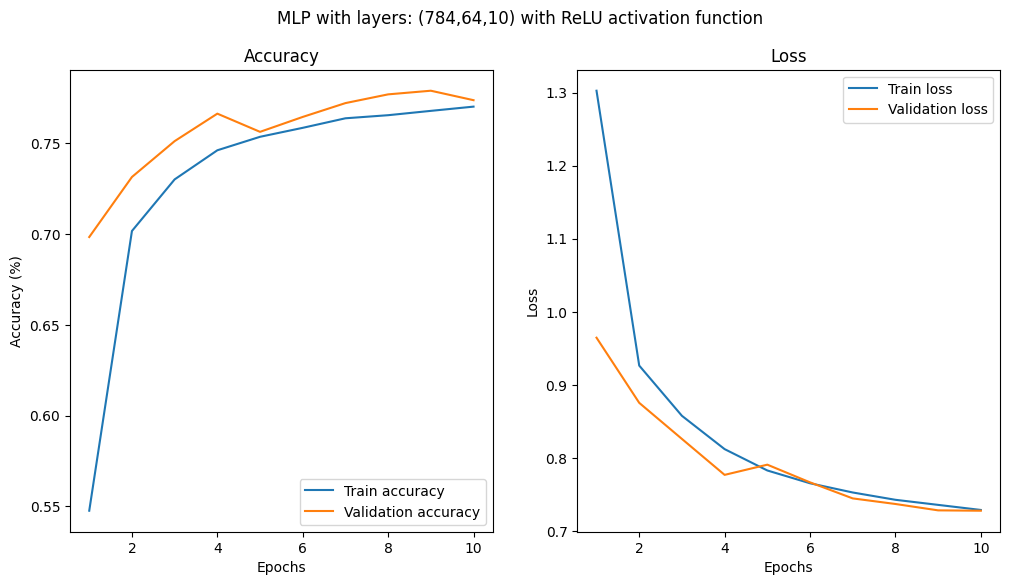

In [8]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_mlp, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_mlp, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_mlp, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_mlp, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('MLP with layers: (784,64,10) with ReLU activation function')
fig.show()

Plotting KAN

/tmp/ipykernel_16179/1405184315.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


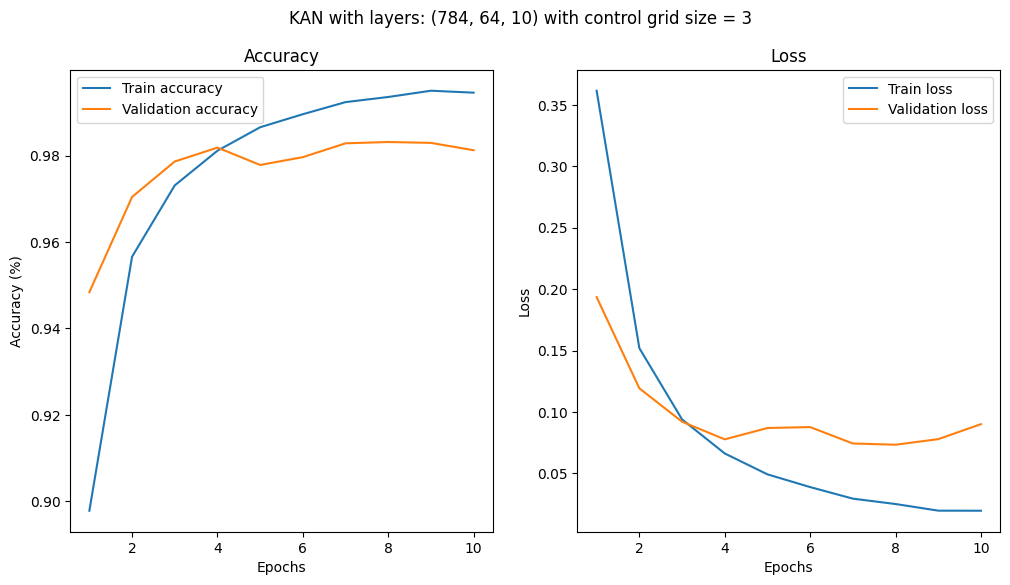

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_kan, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_kan, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_kan, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_kan, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('KAN with layers: (784, 64, 10) with control grid size = 3')
fig.show()